In [2]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

def cls_predictor(num_inputs,num_anchors,num_classes):
    return nn.Conv2d(num_inputs,num_anchors*(num_classes+1),
                     kernel_size=3,padding=1)

In [6]:
#边界框预测
def bbox_predictor(num_inputs,num_anchors):
    return nn.Conv2d(num_inputs,num_anchors*4,kernel_size=3,padding=1)

def forward(x,block):
    return block(x)

def flatten_pred(pred):
    return torch.flatten(pred.permute(0,2,3,1),start_dim=1)

def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

concat_preds([Y1,Y2]).shape

torch.Size([2, 25300])

In [10]:
def down_sample_blk(in_channels, out_channels):
    blk=[]
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels,out_channels, kernel_size=3,padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels=out_channels
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)
def base_net():
    blk=[]
    num_filters=[3,16,32,64]
    for i in range(len(num_filters)-1):
        blk.append(down_sample_blk(num_filters[i],num_filters[i+1]))
    return nn.Sequential(*blk)

In [9]:
forward(torch.zeros((2,3,20,20)),down_sample_blk(3,10)).shape

D:\Anaconda\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([2, 10, 10, 10])

In [13]:
forward(torch.zeros((2,3,256,256)),base_net()).shape

torch.Size([2, 64, 32, 32])

In [14]:
def get_blk(i):
    if (i==0):
        blk=base_net()
    elif (i==1):
        blk=down_sample_blk(64,128)
    elif (i==4):
        blk=nn.AdaptiveMaxPool2d((1,1))
    else:
        blk=down_sample_blk(128,128)
    return blk

In [19]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y=blk(X)
    anchors=d2l.multibox_prior(Y, sizes=size, ratios=ratio)
    cls_pred=cls_predictor(Y)
    bbox_pred=bbox_predictor(Y)
    return (Y, anchors, cls_pred, bbox_pred)

size=[[0.2,0.272],[0.37,0.447],[0.54,0.619],[0.71,0.79],[0.88,0.961]]
ratio=[[1,2,0.5]]*5
num_anchor= len(size[0])+len(ratio[0])-1

In [22]:
class TinySSD(nn.Module):
    def __init__(self,num_classes,**kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes=num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(idx_to_in_channels[i],
                                                   num_anchor, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(idx_to_in_channels[i],num_anchor))
    
    def forward(self, X):
        anchors, cls_preds, bbox_preds= [None]*5, [None]*5, [None]*5
        for i in range(5):
            X, anchors[i], cls_preds[i], bbox_preds[i]= blk_forward(X,
                getattr(self, f'blk_{i}'),size[i],ratio[i],
                getattr(self, f'cls_{i}'),getattr(self, f'bbox_{i}'))
        anchors = torch.cat(anchors, dim=1)
        cls_preds=concat_preds(cls_preds)
        cls_preds=cls_preds.reshape(cls_preds.shape[0],-1,self.num_classes+1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

In [24]:
net = TinySSD(num_classes=1)
X = torch.zeros((32,3,256,256))
anchors, cls_preds, bbox_preds=net(X)

print(anchors.shape)
print(cls_preds.shape)
print(bbox_preds.shape)

torch.Size([1, 5444, 4])
torch.Size([32, 5444, 2])
torch.Size([32, 21776])


In [25]:
batch_size = 32
train_iter, _ = d2l.load_data_bananas(batch_size)

read 1000 training examples
read 100 validation examples


In [26]:
device, net = d2l.try_gpu(), TinySSD(num_classes=1)
trainer= torch.optim.SGD(net.parameters(),lr=0.2,weight_decay=5e-4)

In [33]:
cls_loss= nn.CrossEntropyLoss(reduction='none')
bbox_loss=nn.L1Loss(reduction='none')

In [42]:
def calc_loss(cls_preds, cls_lables, bbox_preds, bbox_lables, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes),cls_lables.reshape(-1)).reshape(batch_size,-1).mean(dim=1)
    bbox = bbox_loss(bbox_preds* bbox_masks, bbox_lables*bbox_masks).mean(dim=1)
    return cls+bbox

In [43]:
def cls_eval(cls_preds, cls_labels):
    # 由于类别预测结果放在最后一维， `argmax` 需要指定最后一维。
    return float((cls_preds.argmax(dim=-1).type(
        cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

class err 3.38e-03, bbox mae 3.55e-03
411.5 examples/sec on cpu


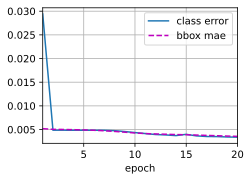

In [44]:
num_epochs, timer = 20, d2l.Timer()
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['class error', 'bbox mae'])
net = net.to(device)
for epoch in range(num_epochs):
    # 训练精确度的和，训练精确度的和中的示例数
    # 绝对误差的和，绝对误差的和中的示例数
    metric = d2l.Accumulator(4)
    net.train()
    for features, target in train_iter:
        timer.start()
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        # 生成多尺度的锚框，为每个锚框预测类别和偏移量
        anchors, cls_preds, bbox_preds = net(X)
        # 为每个锚框标注类别和偏移量
        bbox_labels, bbox_masks, cls_labels = d2l.multibox_target(anchors, Y)
        # 根据类别和偏移量的预测和标注值计算损失函数
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                      bbox_masks)
        l.mean().backward()
        trainer.step()
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                   bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                   bbox_labels.numel())
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    animator.add(epoch + 1, (cls_err, bbox_mae))
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on '
      f'{str(device)}')